# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.


In [1]:

#Initial imports

import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# slicing the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

<AxesSubplot:title={'center':'CAD/JPY Exchange Rates'}, xlabel='Date'>

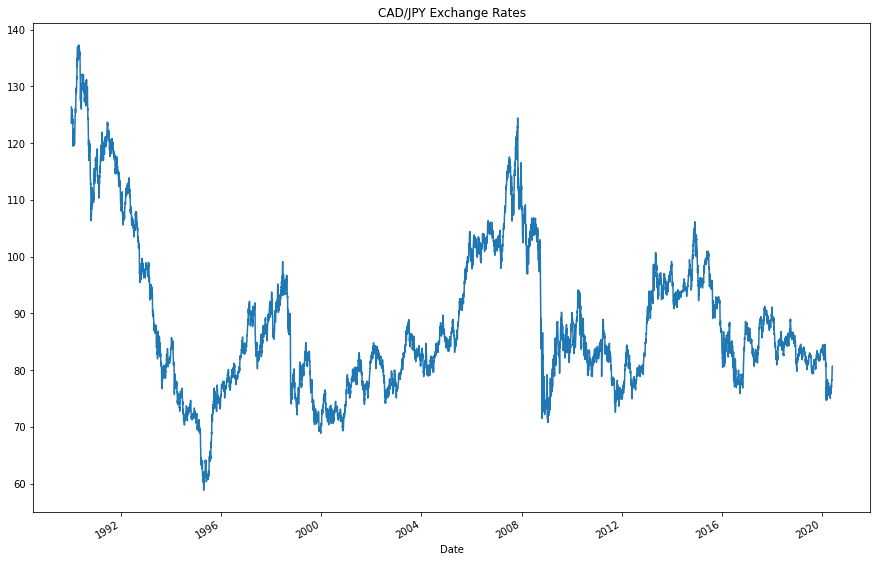

In [4]:
# Plotting just the "Price" column from the dataframe:
cad_jpy_df['Price'].plot(title='CAD/JPY Exchange Rates', xlabel='Date', figsize=(15,10))

**Question:** Do you see any patterns, long-term and/or short? 

Theres a certain type of trend happening every year through out the period. 

---

# Decomposition Using a Hodrick-Prescott Filter

In [5]:
# Applying the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:

import statsmodels.api as sm

ts_noise, ts_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])


In [6]:
# Creating a dataframe of just the exchange rate price, and adding columns for "noise" and "trend" series from above:

df_ex_price = cad_jpy_df['Price'].to_frame()
df_ex_price['noise'] = ts_noise
df_ex_price['trend'] = ts_trend

df_ex_price

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037
...,...,...,...
2020-05-29,78.29,-0.503961,78.793961
2020-06-01,79.27,0.218939,79.051061
2020-06-02,80.40,1.088117,79.311883


<AxesSubplot:title={'center':'Price vs. Trend'}, xlabel='Date'>

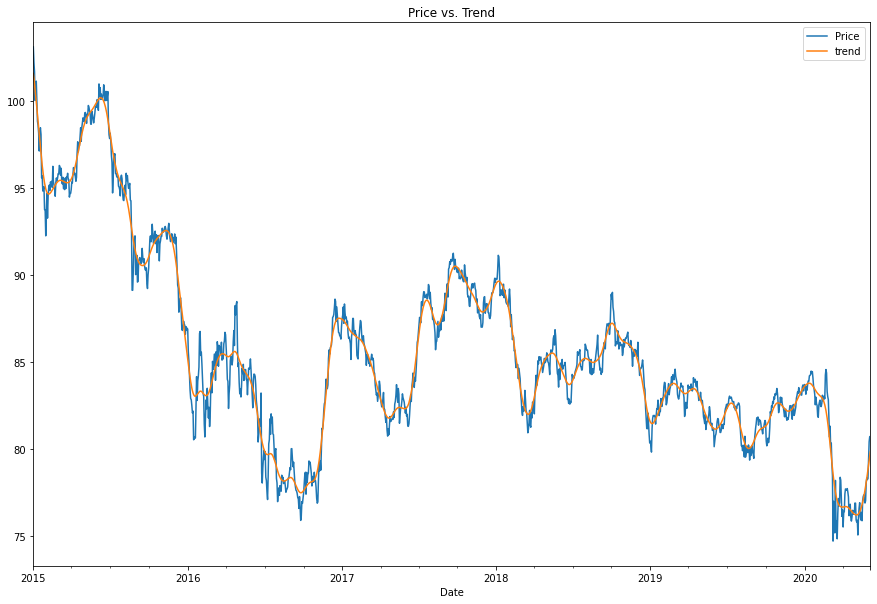

In [7]:
# Plotting the Exchange Rate Price vs. the Trend for 2015 to the present

data_2015 = df_ex_price.loc['2015':]

data_2015 = data_2015.drop('noise',axis=1)

data_2015.plot(title='Price vs. Trend', xlabel='Date', figsize=(15,10))


<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

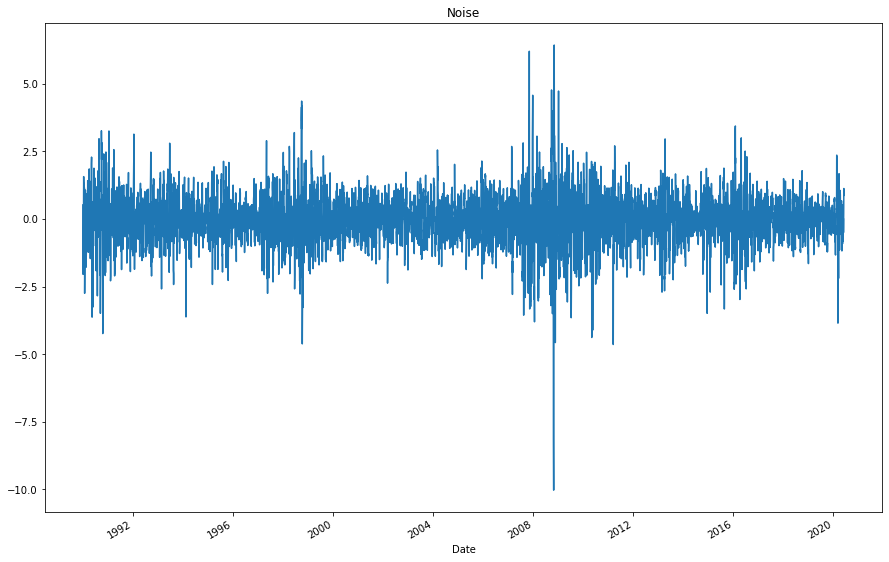

In [8]:
# Plotting the Settle Noise

df_ex_price['noise'].plot(title='Noise', xlabel='Date', figsize=(15,10))

# Forecasting Returns using an ARMA Model

In [9]:
# Creating a series using "Price" percentage returns

returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [10]:
# creating ARMA model using statsmodels (using order=(2, 1))

from statsmodels.tsa.arima_model import ARMA

model = ARMA(returns.values, order=(2,1))

# Fitting the model and assigning it to a variable called results
results = model.fit()


In [11]:
# Generating output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Fri, 29 Oct 2021   AIC                          19513.955
Time:                        06:42:05   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1704           +0.0000j           42.1704            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

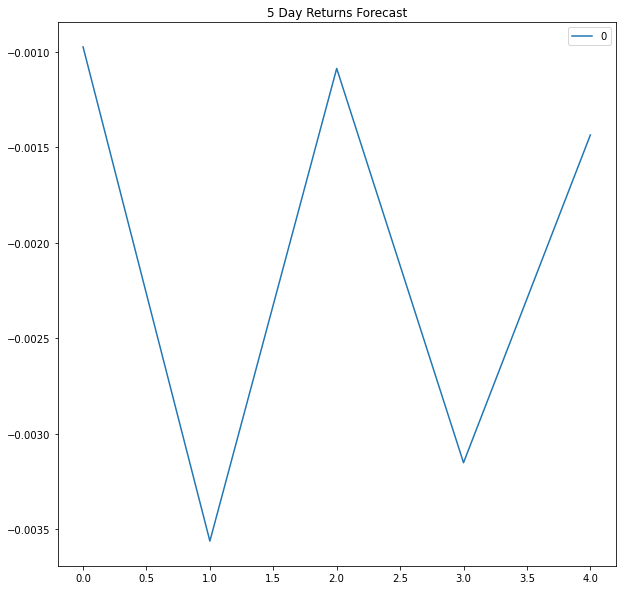

In [12]:
# Plotting the 5 Day Returns Forecast

pd.DataFrame(results.forecast(steps=5)[0]).plot(title='5 Day Returns Forecast', figsize=(10,10))

**Question:** Based on the p-value, is the model a good fit?

This model is not a good fit.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

In [13]:
# Estimate and ARIMA Model:

from statsmodels.tsa.arima_model import ARIMA

model1 = ARIMA(cad_jpy_df['Price'], order=(5,1,1))


# Fitting the model

result1 = model1.fit()


C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [14]:
# Generating Output model summary results:

result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Fri, 29 Oct 2021   AIC                          17507.244
Time:                        06:42:07   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.856      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1893           +0.0000j            2.1893            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}>

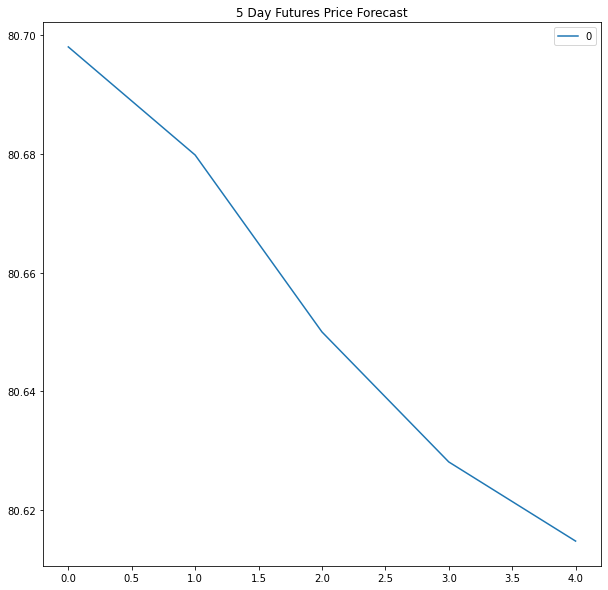

In [15]:
# Plotting the 5 Day Price Forecast

pd.DataFrame(result1.forecast(steps=5)[0]).plot(title='5 Day Futures Price Forecast', figsize=(10,10))

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

According to forecast, Japanese Yen will become stronger against Canadian dollar and one can expect low yen returns on exchange during the forecasted period.

---

# Volatility Forecasting with GARCH



In [16]:
# Importing arch_model

from arch import arch_model

In [17]:
# Estimating GARCH model:
model2 = arch_model(returns, mean='zero', vol='GARCH', p = 2, q=1)

# Fitting the model
results2 = model2.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46548.40924082976
Iteration:      2,   Func. Count:     16,   Neg. LLF: 306850859.3384427
Iteration:      3,   Func. Count:     22,   Neg. LLF: 8928.838861417698
Iteration:      4,   Func. Count:     27,   Neg. LLF: 11771.663036006626
Iteration:      5,   Func. Count:     33,   Neg. LLF: 10426.31072801688
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8916.369930732108
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8911.112105819691
Iteration:      8,   Func. Count:     52,   Neg. LLF: 8911.027322298947
Iteration:      9,   Func. Count:     57,   Neg. LLF: 8911.022077988246
Iteration:     10,   Func. Count:     62,   Neg. LLF: 8911.021067661106
Iteration:     11,   Func. Count:     67,   Neg. LLF: 8911.020797453917
Iteration:     12,   Func. Count:     72,   Neg. LLF: 8911.020764880363
Iteration:     13,   Func. Count:     76,   Neg. LLF: 8911.020764882265
Optimization terminated successfully    (Exit mode 0)
         

In [18]:
# Generating the model results summary
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Fri, Oct 29 2021   Df Residuals:                     7928
Time:                        06:42:08   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

In [19]:
# Finding the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [20]:
# Creating a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecast = results2.forecast(start='2020-06-04', horizon=forecast_horizon)
forecast

In [21]:
# Annualizing the forecast
intermediate = np.sqrt(forecast.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566029,12.573718,12.581301,12.588778,12.596153


In [22]:
# Transposing the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566029
h.2,12.573718
h.3,12.581301
h.4,12.588778
h.5,12.596153


<AxesSubplot:title={'center':'5 Day Forecast of Volatility'}>

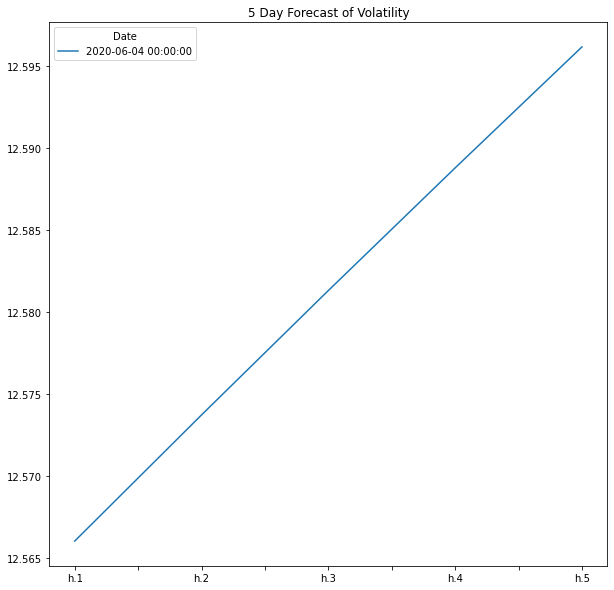

In [23]:
# Plotting the final forecast
final.plot(title='5 Day Forecast of Volatility', figsize=(10,10))

**Question:** What does the model forecast will happen to volatility in the near term?

According to forecast a higher rate of volatility is expected during the coming days

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

Based on the analysis, I wouldnt buy Yen now as the market seems highly volatile and is set to become more

2. Is the risk of the yen expected to increase or decrease?

The risk of the yen is expected to increase.

3. Based on the model evaluation, would you feel confident in using these models for trading?

 Based on the evaluation above, the model looks decent, but I would still be hesitant using it as i beleive it can still be improved with better combinations